In [1]:
import gzip
import random
import matplotlib.pyplot as plt
import string
from sklearn import svm
from collections import defaultdict

### Question 1

In [2]:
def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

In [3]:
train = []
for l in readGz("train.json.gz"):
    train.append(l)

In [4]:
notPurchased = []
for i in range(0, 100000):
    user = random.randint(0, 99999)
    product = random.randint(0, 99999)
    v = {'reviewerID' : 0,
        'itemID' : 0}
    v['reviewerID'] = train[user]['reviewerID']
    v['itemID'] = train[user]['itemID']
    notPurchased.append(v)

In [5]:
validation = train[100000:]
train = train[:100000]

In [6]:
validation = validation + notPurchased

In [7]:
### Would-purchase baseline: just rank which businesses are popular and which are not, and return '1' if a business is among the top-ranked

businessCount = defaultdict(int)
totalPurchases = 0

for l in train:
  user,business = l['reviewerID'],l['itemID']
  businessCount[business] += 1
  totalPurchases += 1

In [8]:
mostPopular = [(businessCount[x], x) for x in businessCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
  count += ic
  return1.add(i)
  if count > totalPurchases/2: break

In [9]:
validationResult = []
expectedResult = []
i = 0
for v in validation:
    if v['itemID'] in return1:
        validationResult.append(1)
    else:
        validationResult.append(0)
    if i < 100000:
        expectedResult.append(1)
    else:
        expectedResult.append(0)
    i = i+1

In [10]:
comparison = list(zip(validationResult, expectedResult))
accuracyV = [v[0] == v[1] for v in comparison]
accuracy = sum(accuracyV)/len(accuracyV)

In [11]:
accuracy

0.47252

### Question 2

In [12]:
### Would-purchase baseline: just rank which businesses are popular and which are not, and return '1' if a business is among the top-ranked

def predict(X, percentile):
    return1 = set()
    count = 0
    for ic, i in mostPopular:
      count += ic
      return1.add(i)
      if count > totalPurchases*percentile: break

    validationResult = []
    for v in X:
        if v['itemID'] in return1:
            validationResult.append(1)
        else:
            validationResult.append(0)
            
    return validationResult

def modelAccuracy(y, real_y):
    comparison = list(zip(y, real_y))
    accuracyV = [v[0] == v[1] for v in comparison]
    return sum(accuracyV)/len(accuracyV)

In [15]:
percent = []
res = []
for i in range(0, 101):
    percentile = i/100
    percent.append(percentile)
    result = predict(validation, percentile)
    acc = modelAccuracy(result, expectedResult)
    res.append(acc)

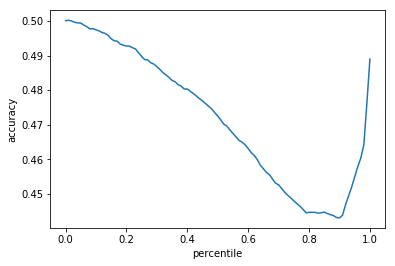

In [16]:
plt.plot(percent, res)
plt.xlabel('percentile')
plt.ylabel('accuracy')
plt.show()

In [19]:
percent[res.index(max(res))]

0.01

In [20]:
max(res)

0.500185

The best performance is achieved when using the 1st percentile. The accuracy is 0.500185

### Question 3

In [25]:
predictions = open("predictions_Purchase.txt", 'w')
for l in open("pairs_Purchase.txt"):
    if l.startswith("reviewerID"):
        #header
        predictions.write(l)
        continue
    u,i = l.strip().split('-')

    userCategories = list(set([v['categoryID'] for v in train if v['reviewerID'] == u]))
    itemCat = list(set([v['categoryID'] for v in train if v['itemID'] == i]))
    if itemCat != []:
        itemCat = itemCat[0]
    
    if itemCat != [] and itemCat in userCategories:
        predictions.write(u + '-' + i + ",1\n")
    else:
        predictions.write(u + '-' + i + ",0\n")

predictions.close()

### Question 4

Username: psousame

Team Name: Pedro Meireles

### Question 5

In [23]:
train = []
for l in readGz("train.json.gz"):
    train.append(l)

In [24]:
subSet = []
for i in range(0, 20000):
    index = random.randint(0, 19999)
    subSet.append(train[index])

In [25]:
validation = subSet[len(subSet)//2:]
train = subSet[:len(subSet)//2]

In [12]:
usersCats = defaultdict(list)
for v in train:
    user = v['reviewerID']
    usersCats[user] = [0,0,0,0,0]

mostCommonCat = [0,0,0,0,0]
for v in train:
    user = v['reviewerID']
    index = v['categoryID']
    usersCats[user][index] = usersCats[user][index] + 1
    mostCommonCat[index] = mostCommonCat[index] + 1

In [13]:
for v in usersCats:
    maxIndices = [i for i, x in enumerate(usersCats[v]) if x == max(usersCats[v])]
    catID = [mostCommonCat[i] for i in maxIndices]
    catID = maxIndices[catID.index(max(catID))]
    usersCats[v] = catID

In [8]:
predictions = []
actualValue = []
for l in validation:
    user = l['reviewerID']
    if user in usersCats:
        predictions.append(usersCats[user])
    else:
        predictions.append(0)
    actualValue.append(l['categoryID'])

In [9]:
comparison = list(zip(predictions, actualValue))
accuracy = [v[0] == v[1] for v in comparison]
accuracy = sum(accuracy)/len(accuracy)
accuracy

0.8187

In [14]:
predictions = open("predictions_Category.txt", 'w')
for l in open("pairs_Category.txt"):
    if l.startswith("reviewerID"):
        #header
        predictions.write(l)
        continue
    u,i = l.strip().split('-')

    if u in usersCats:
        predictions.write(u + '-' + i + "," + str(usersCats[u]) + "\n")
    else:
        predictions.write(u + '-' + i + ",0\n")

predictions.close()

### Question 6

In [15]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for v in train:
    r = ''.join([c for c in v['reviewText'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

In [16]:
wordCount = [(wordCount[w], w) for w in wordCount]
wordCount.sort()
wordCount.reverse()

In [17]:
totalWords = sum([v[0] for v in wordCount])

In [18]:
frequency = [(v[0]/totalWords, v[1]) for v in wordCount]

In [19]:
catWordCount = [defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)]
catTotalWords = [0, 0, 0, 0, 0]
catFrequency = []
for i in range(0, 5):
    for v in [v for v in train if v['categoryID'] == i]:
        r = ''.join([c for c in v['reviewText'].lower() if not c in punctuation])
        for w in r.split():
            catWordCount[i][w] += 1
    
    catWordCount[i] = [(catWordCount[i][w], w) for w in catWordCount[i]]
    catWordCount[i].sort()
    catWordCount[i].reverse()
    
    catTotalWords[i] = sum([v[0] for v in catWordCount[i]])
    catFrequency.append([(v[0]/catTotalWords[i], v[1]) for v in catWordCount[i]])

In [20]:
for i in range(0, 5):
    print('CategoryID = ' + str(i))
    for v in catFrequency[i][:10]:
        f = v[0] - [x[0] for x in frequency if x[1] == v[1]][0]
        print(v[1] + ' - ' + str(f))
    print()

CategoryID = 0
the - -0.0001830118442185738
i - 0.0033639416588894383
and - 0.00013154814794518604
a - 0.00017151733026209842
it - 0.0013979045179383365
to - -5.735199828152404e-05
is - -1.8542851970240748e-05
for - -0.0006914201788361021
this - 0.0003678141018239392
in - 0.00016154547404756588

CategoryID = 1
the - 0.0007219045468786905
i - -0.00725930284502313
and - -0.000475814828130805
a - -2.874195769825283e-05
to - 0.00019532598714466776
is - -7.155610571632845e-05
it - -0.003432213312138343
for - 0.0012323506655017892
of - 0.0012031414365440852
in - -0.00028453338477869676

CategoryID = 2
the - -0.0025907973113547325
and - 0.0016222582519749493
i - -0.008940365249605942
a - -0.001840804437797234
it - 0.003825898935718528
to - 0.00037173734580276535
for - 0.0045828249158813145
is - 0.0017084864812889032
my - 0.004234039467868931
this - 0.0011560368560521832

CategoryID = 3
the - -0.0017261461279429666
and - 0.0005600184426730673
a - -0.0026411741360753346
i - -0.01568057459725203

### Question 7

In [26]:
X_train = []
y_train = []
X_validation = []
y_validation = []
for v in train:
    if v['categoryID'] != 0:
        v['categoryID'] = 1
    features = []
    for i in range(0, 500):
        features.append(frequency[i][1] in v['reviewText'])
    y_train.append(v['categoryID'])
    X_train.append(features)
    
        
for v in validation:
    if v['categoryID'] != 0:
        v['categoryID'] = 1
    features = []
    for i in range(0, 500):
        features.append(frequency[i][1] in v['reviewText'])
    y_validation.append(v['categoryID'])
    X_validation.append(features)

In [27]:
test_accuracies = []
svms = []
for c in [0.01, 0.1, 1, 10, 100]:
    clf = svm.SVC(C=c, kernel='linear')
    clf.fit(X_train, y_train)
    test_predictions = clf.predict(X_validation)
    accuracy = []
    for i in range(0, len(test_predictions)):
        accuracy.append(test_predictions[i] == y_validation[i])
    test_accuracies.append((c, sum(accuracy)/len(accuracy)))
    svms.append(clf)

1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5


In [28]:
test_accuracies

[(0.01, 0.7714), (0.1, 0.7915), (1, 0.7908), (10, 0.7933), (100, 0.7918)]

The best performance was an accuracy of 0.7933 using C = 10

### Question 8

In [51]:
newTrain = train[:10000]
newValidation = validation[:10000]

In [52]:
allPredictions = []
allSvms = []
realValidationY = [v['categoryID'] for v in newValidation]
for c in [0.01, 0.1, 1, 10, 100]:
    svms = []
    print(str(c))
    for i in range(0, 5):
        print('Category = ' + str(i))
        X_train = []
        y_train = []
        X_validation = []
        y_validation = []
        for v in newTrain:
            if v['categoryID'] != i:
                v['categoryID'] = (i+1)%5
            features = []
            for j in range(0, 500):
                features.append(frequency[j][1] in v['reviewText'])
            y_train.append(v['categoryID'])
            X_train.append(features)


        for v in newValidation:
            if v['categoryID'] != i:
                v['categoryID'] = (i+1)%5
            features = []
            for j in range(0, 500):
                features.append(frequency[j][1] in v['reviewText'])
            y_validation.append(v['categoryID'])
            X_validation.append(features)

        test_accuracies = []

        clf = svm.SVC(C=c, kernel='linear')
        clf.fit(X_train, y_train)
        print('Fit done')
        svms.append(clf)
        
    test_predictions = []
    print('Predicting')
    for v in X_validation:
        confidency = [svms[j].decision_function([v]) for j in range(0, 5)]
        posConf = [x for x in confidency if x > 0]
        posConf.sort()
        if posConf == []:
            test_predictions.append(0)
        else:
            test_predictions.append(confidency.index(posConf[0]))
    allPredictions.append([c, test_predictions])
    allSvms.append(svms)
    print('Finished')
    print()

0.01
Category = 0
Fit done
Category = 1
Fit done
Category = 2
Fit done
Category = 3
Fit done
Category = 4
Fit done
Predicting
Finished

0.1
Category = 0
Fit done
Category = 1
Fit done
Category = 2
Fit done
Category = 3
Fit done
Category = 4
Fit done
Predicting
Finished

1
Category = 0
Fit done
Category = 1
Fit done
Category = 2
Fit done
Category = 3
Fit done
Category = 4
Fit done
Predicting
Finished

10
Category = 0
Fit done
Category = 1
Fit done
Category = 2
Fit done
Category = 3
Fit done
Category = 4
Fit done
Predicting
Finished

100
Category = 0
Fit done
Category = 1
Fit done
Category = 2
Fit done
Category = 3
Fit done
Category = 4
Fit done
Predicting
Finished



In [53]:
test_accuracies = []
for v in allPredictions:
    predicted = v[1]
    accuracy = []
    for i in range(0, len(predicted)):
        accuracy.append(predicted[i] == realValidationY[i])
    test_accuracies.append((v[0], sum(accuracy)/len(accuracy)))

In [54]:
test_accuracies

[(0.01, 0.2286), (0.1, 0.7914), (1, 0.2089), (10, 0.7929), (100, 0.2082)]

In [55]:
test = []
for l in readGz("test_Category.json.gz"):
    test.append(l)

In [56]:
X_test=[]
for v in test:
    features = []
    for i in range(0, 500):
        features.append(frequency[i][1] in v['reviewText'])
    X_test.append(features)

In [60]:
predictions = open("predictions_Category.txt", 'w')
i = 0
for l in open("pairs_Category.txt"):
    if l.startswith("reviewerID"):
        #header
        predictions.write(l)
        continue
    u,r = l.strip().split('-')
    
    confidency = [allSvms[3][j].decision_function([X_test[i]]) for j in range(0, 5)]
    posConf = [x for x in confidency if x > 0]
    posConf.sort()
    if posConf == []:
        predictions.write(u + '-' + r + ',0\n')
    else:
        predictions.write(u + '-' + r + ',' + str(confidency.index(posConf[0])) + '\n')
    i += 1
predictions.close()